In [1]:
! pip install -Uqq fastbook

In [2]:
from fastbook import *
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
csv_path = "/kaggle/input/paddy-disease-classification/train.csv"

In [5]:
df = pd.read_csv(csv_path)

In [7]:
ddf = df.drop(columns=["variety", "age"], axis=1)

In [8]:
ddf

,image_id,label
0,100330.jpg,bacterial_leaf_blight
1,100365.jpg,bacterial_leaf_blight
2,100382.jpg,bacterial_leaf_blight
3,100632.jpg,bacterial_leaf_blight
4,101918.jpg,bacterial_leaf_blight
...,...,...
10402,107607.jpg,tungro
10403,107811.jpg,tungro
10404,108547.jpg,tungro
10405,110245.jpg,tungro


In [9]:
ddf.shape

(10407, 2)

In [13]:
dblock = DataBlock()
dsets = dblock.datasets(ddf)
len(dsets.train), len(dsets.valid)

(8326, 2081)

In [15]:
x,y = dsets.train[0]
x, y

(image_id    103208.jpg
 label       dead_heart
 Name: 4235, dtype: object,
 image_id    103208.jpg
 label       dead_heart
 Name: 4235, dtype: object)

In [10]:
train_path = "/kaggle/input/paddy-disease-classification/train_images"

In [47]:
im = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.25, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [48]:
dls = im.dataloaders(train_path)

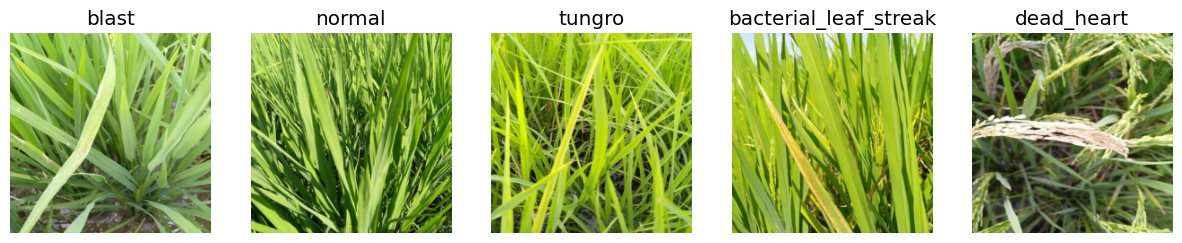

In [49]:
dls.valid.show_batch(nrows=1, ncols=5)

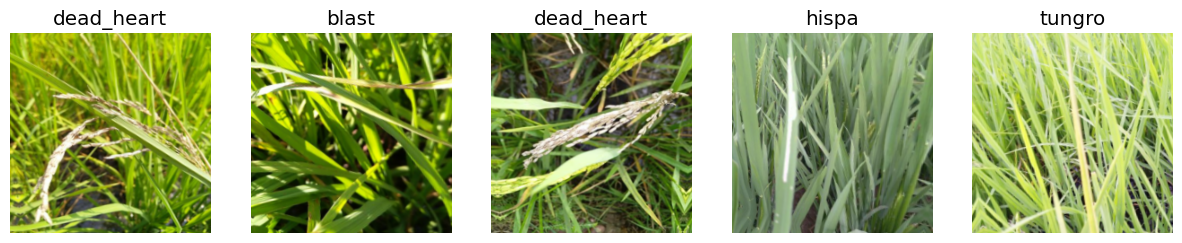

In [50]:
dls.train.show_batch(nrows=1, ncols=5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 272MB/s]


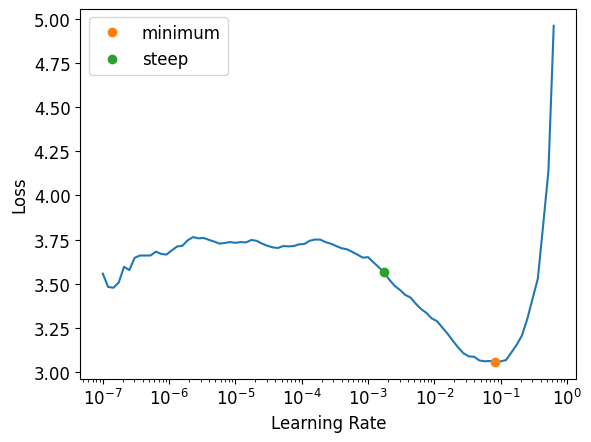

In [51]:
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy])
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.915316,1.112999,0.355248,0.644752,00:44


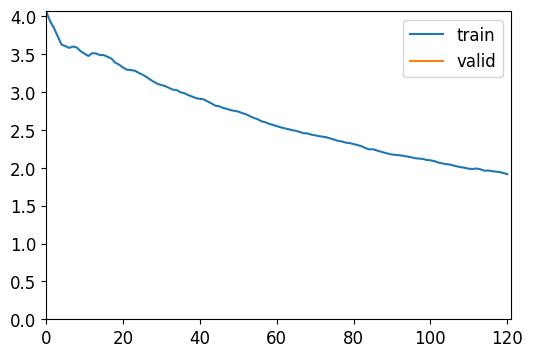

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.916203,0.557917,0.181853,0.818147,00:43
1,0.618841,0.393075,0.118416,0.881584,00:44
2,0.487444,0.388875,0.116109,0.883891,00:45
3,0.412394,0.461093,0.139946,0.860054,00:44
4,0.400031,0.540720,0.150327,0.849673,00:45
5,0.340963,0.376343,0.103806,0.896194,00:44
6,0.284345,0.293171,0.080354,0.919646,00:45
7,0.244110,0.378344,0.099193,0.900807,00:44
8,0.207551,0.280628,0.082661,0.917340,00:45
9,0.181288,0.239754,0.060746,0.939254,00:45


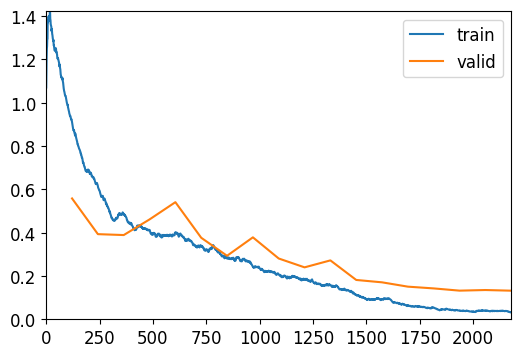

In [52]:
learn.fine_tune(18, base_lr=5e-3, cbs=[ShowGraphCallback()])

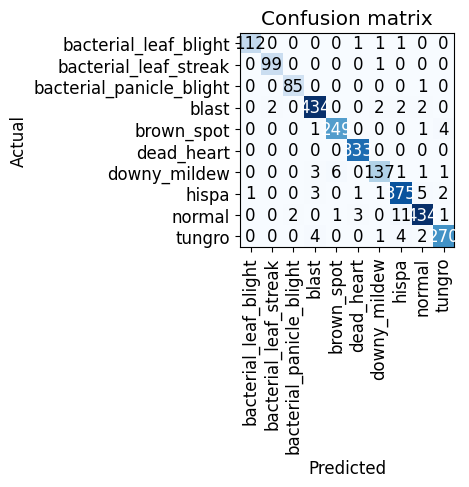

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

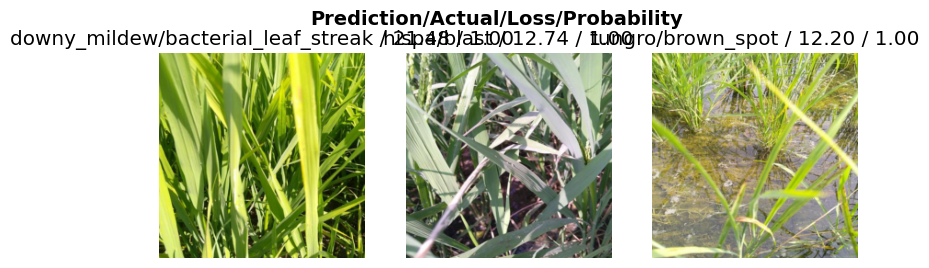

In [54]:
interp.plot_top_losses(3, nrows=1)

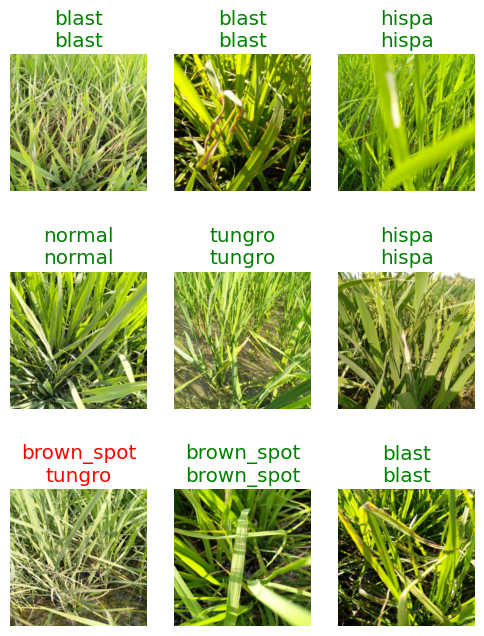

In [55]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))


In [56]:
learn.export('model_97_2_resnet34')

In [57]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0281)

In [58]:
# Get TTA (Test Time Augmentation) predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0273)

In [61]:
train_path

test_path = "/kaggle/input/paddy-disease-classification/test_images"
test_files = get_image_files(test_path).sorted()

In [62]:
# TTA predictions from test images
probs, _ = learn.tta(dl=dls.test_dl(test_files))

In [63]:
# get the index with the greater probability
preds = probs.argmax(dim=1)

In [64]:
dls.vocab[preds]


(#3469) ['hispa','normal','blast','blast','blast','brown_spot','dead_heart','brown_spot','hispa','normal'...]

In [67]:
# sample submission
sample_submission = pd.read_csv("/kaggle/input/paddy-disease-classification/sample_submission.csv")


sample_submission.label = dls.vocab[preds]
sample_submission.to_csv('submission.csv', index=False)

In [68]:
fdf = pd.read_csv('/kaggle/working/submission.csv')

In [69]:
fdf

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak
